# Differential Side-channel Analysis on Advanced Encryption Standard (AES)


<img src="images/KeyBits.jpg" width="200px">

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
graph_title_fontsize = 14

### Load the traces

In [2]:
import estraces

In [3]:
ths = estraces.read_ths_from_ets_file("../BZR/AES_traces_set.ets")
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../BZR/AES_traces_set.ets with 2000 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



#### Are the traces misaligned?

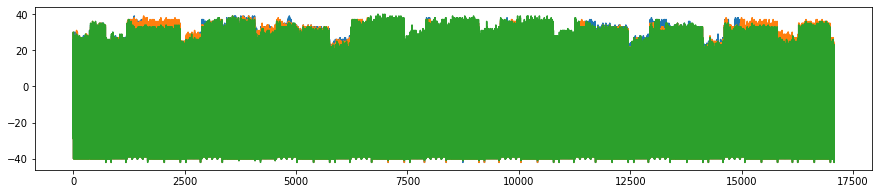

In [4]:
plt.rcParams['figure.figsize']=(15,3)
plt.plot(ths[0:3].samples.T)
plt.show()

#### We can perform running mean, sum and var on the trace using esDynamic.

In [5]:
from scared.signal_processing import moving_operators as mov, pattern_detection as patt

In [6]:
def Plot_Basic_SP(period, trace):
    plt.rcParams["figure.figsize"] = [20, 7]
    plt.subplots_adjust(hspace=0.5)    
    
    #plot running average of traces
    plt.subplot(3,1,1)
    plt.title('Fig.2-1: Running average', fontsize= graph_title_fontsize)
    plt.plot(mov.moving_mean(trace,period).T)
    #plot running variance of traces
    plt.subplot(3,1,2)    
    plt.title('Fig.2-2: Running variance', fontsize= graph_title_fontsize)    
    plt.plot(mov.moving_var(trace,period).T)
    #plot running sum of traces
    plt.subplot(3,1,3)    
    plt.title('Fig.2-3: Running sum', fontsize= graph_title_fontsize)        
    plt.plot(mov.moving_sum(trace,period).T)
    
    plt.show()

Let's play with the pattern array parameter in the following widget to observe the recognition pattern results.

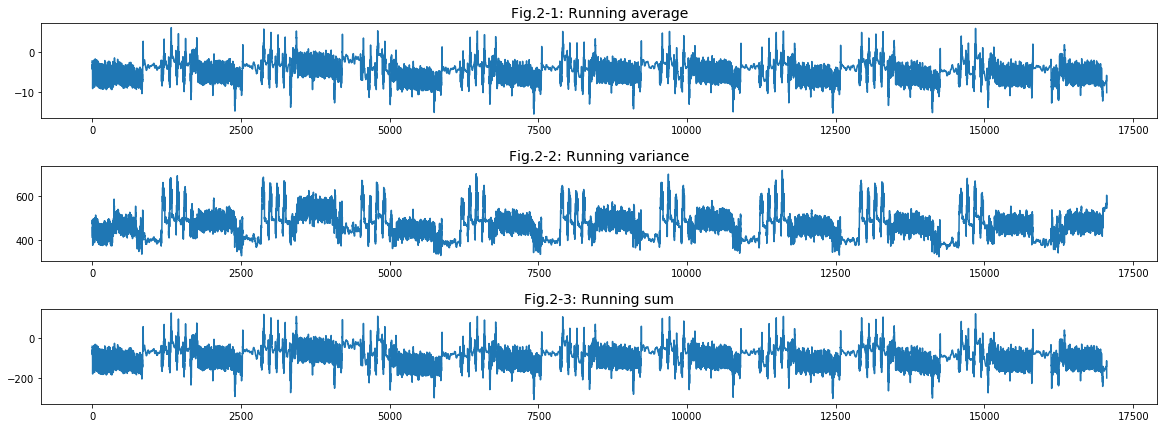

In [7]:
trace = ths.samples[0]
Plot_Basic_SP(20, trace)

In [8]:
def Plot_Pattern_SP(LeftWindowPoint, WdwRight, trace_pattern):
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.subplots_adjust( hspace=0.5)    

    # plot the original AES trace
    plt.subplot(4,1,1)
    plt.title('Fig.3-1: AES original trace', fontsize= graph_title_fontsize)
    plt.plot(trace_pattern.T)
    plt.axvspan(LeftWindowPoint, WdwRight, facecolor='red', alpha=0.3, label='Window area selected')    
    # plot cross correlation
    plt.subplot(4,1,2)
    plt.title('Fig.3-2: Pattern Correlation', fontsize= graph_title_fontsize)
    plt.plot(patt.correlation(trace_pattern.T,trace_pattern.T[LeftWindowPoint:WdwRight]))
    # plot sliding BCDC
    plt.subplot(4,1,3)    
    plt.title('Fig.3-3: Sliding BCDC', fontsize= graph_title_fontsize)    
    plt.plot(patt.bcdc(trace_pattern.T, trace_pattern.T[LeftWindowPoint:WdwRight]))
    # plot sliding ED
    plt.subplot(4,1,4)    
    plt.title('Fig.3-4: Sliding Euclidean distance', fontsize= graph_title_fontsize)        
    plt.plot(patt.distance(trace_pattern.T, trace_pattern.T[LeftWindowPoint:WdwRight]))
   
    plt.show()     

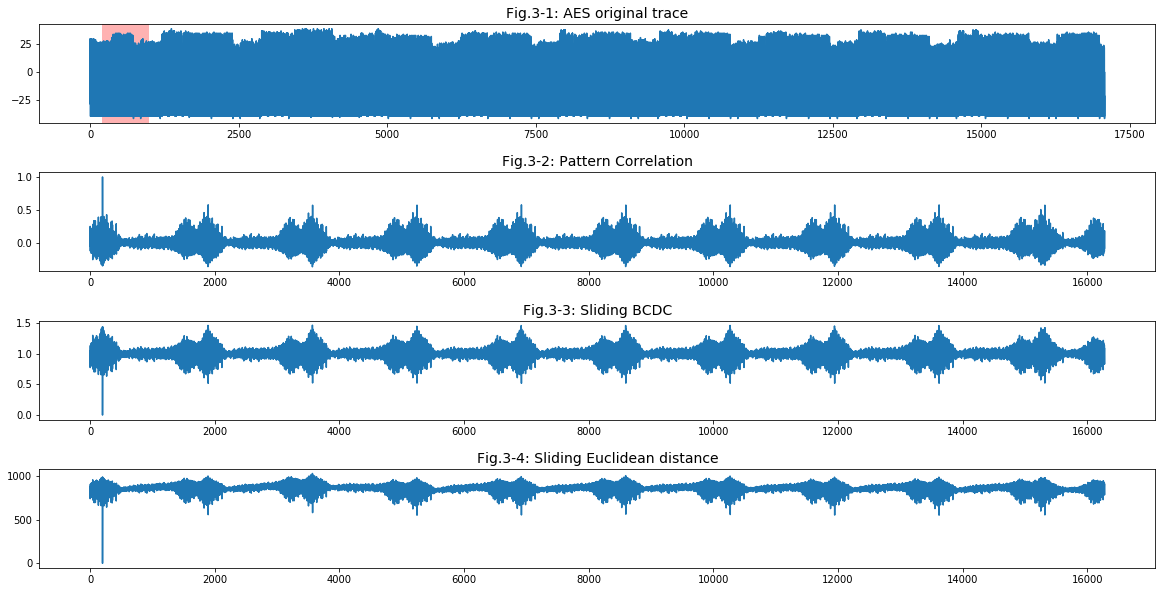

In [9]:
trace_pattern = ths.samples[0]
Plot_Pattern_SP(200,1000, trace_pattern)

#### Depending on the window size we can see only the number of AES rounds, or the number of inner rounds operation like the Sboxes ...

### We see that we easily distinguish the AES 10 rounds and seven some of the operations, for instance the MixColumn that is not present in the last round.

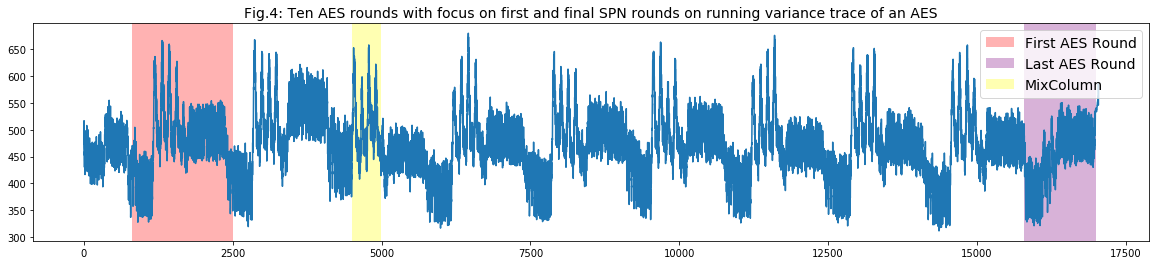

In [10]:
plt.rcParams["figure.figsize"] = [20, 4]
RoundOne = range(800,2500)
RoundTen = range(15800,17000)
MixColumn = range(4500,5000)
period = 30

plt.axvspan(RoundOne[0], RoundOne[len(RoundOne)-1], facecolor='red', alpha=0.3, label='First AES Round')
plt.axvspan(RoundTen[0], RoundTen[len(RoundTen)-1], facecolor='purple', alpha=0.3, label='Last AES Round')
plt.axvspan(MixColumn[0], MixColumn[len(MixColumn)-1], facecolor='yellow',alpha=0.3, label='MixColumn')
plt.plot(mov.moving_var(trace,period).T)
plt.legend(prop={'size': 14})   
plt.title("Fig.4: Ten AES rounds with focus on first and final SPN rounds on running variance trace of an AES", fontsize= graph_title_fontsize)
 
plt.show()

# We run the standard DPA attack
What are we going to find?

<img src="images/openTheDoor.jpeg" width="200px">

 # Import needed libraries

## Targeting the intermediate computations in the AES

As explained previously this attack technique needs to perform guesses on a part of the key (divide-and-conquer approach) and for each guess, knowing the plaintext (resp. the ciphertext) we can compute the intermediate data that is manipulated by the targeted device during the computation. Of course only the right guess will lead the values really manipulated by the device. In that case the DPA attack will succeed and gives the information the guess leading to highest DPA peak matches with the secret key.

<img src="images/AESscheme.png" width="300px">

### Attacking the first round
Knowing the plaintexts (AES inputs) we know the value given as input to the first AES (SPN) round.
Performing guesses on each key byte we can guess all the intermediate values of the first round and and use these values with DPA to exploit the related side-channel trace collected by performing the attack.
It can be the output of the key addition, the output of the Subbytes operations, and even in the MixColumn when using chosen messages.

### Attacking the ten-th (last) round
Knowing the ciphertexts (AES outputs) we can for a key byte guess revert the intermediate computation until the input of the last Subbytes operation.
Performing guesses on each key byte we can guess all the intermediate values of last AES round and and use these values with DPA to exploit the related side-channel trace collected by performing the attack.

#### We select the leakage model we want to consider

In [11]:
import scared

In [12]:
# We select the selection function we target as intermediate result
sel = scared.aes.selection_functions.encrypt.FirstSubBytes()

# We select as leakage model the data Hamming Weight or a single bit 
M = scared.Monobit(1)

# We select the Maximum Absolute of the trace result as the discrimant. Best score is the best candidate.
d = scared.maxabs

Define the trace container for the attack

In [13]:
container = scared.Container(ths)

### Now, we are all set to attack

In [14]:
attack_dpa = scared.DPAAttack(
                selection_function=sel, 
                model=M, 
                discriminant=d)

### Run it !

In [15]:
attack_dpa.run(container)

## Let's see the Results

In [16]:
from sys import path

In [17]:
path.append('/Users/bfeix/_Cyrano/Jupyter/a_helper')
#path

In [18]:
from plot_and_show_results import plot_attack_result, print_attack_result, attack_entropy

In [19]:
print_attack_result(attack_dpa, ths[0].key)

__Best guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess |0x8f|0x3|0xe7|0x7a|0xec|0x66|0x58|0xa|0x13|0x2b|0xd2|0x3b|0xf5|0x63|0x4e|0xf
score |1.24481|0.94046|1.04130|0.98796|1.63558|1.08301|1.08872|1.26341|1.46701|1.08958|1.12482|1.07308|1.66218|0.94651|1.07883|1.15304
right key |0x8f|0x3|0xe7|0x7a|0xec|0x66|0x58|0xa|0x13|0x2b|0xd2|0x3b|0xf5|0x63|0x4e|0xf
rank |1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1

## The AES (first round) key is recovered

### Plot the result


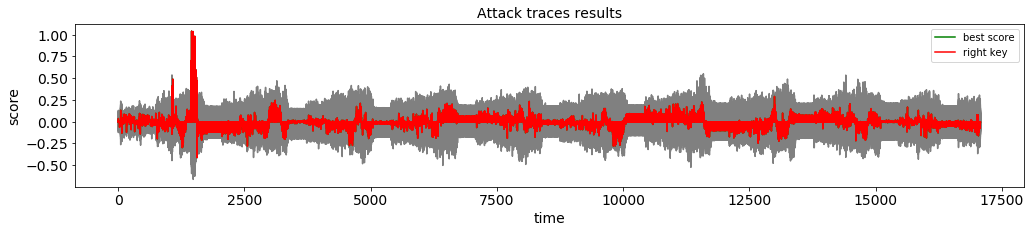

Best guess for byte 2 = 0xe7
Correct guess for byte : 2=0xe7


In [20]:
plot_attack_result(attack_dpa, 2, ths[0].key)

### You can also refine the attack more cleverly using more options

* From the previous result we have identified the area of interest is RoundOne = range(800,2500).
* Let's refine the attack more cleverly the attack on the precise area for the attack frame
* Let say we need only the first 3000 points which includes RoundOne
* you can also observe the attack result at different steps (traces number used) among the whole set of used traces in the ths, for instance each 10% of traces.


In [21]:
# Reduce the number of traces, no need for 2000 traces.
traces_number_selected = 1000

#define the frame
container_precise = scared.Container(ths[:traces_number_selected], frame=range(0,3000))

# We define a convergence step, here each 1/10 of traces used. 
convergence_step = len(ths) // 10

In [22]:
attack_dpa_1stRound = scared.DPAAttack(
                selection_function=sel, 
                model=M, 
                discriminant=d,
                convergence_step =traces_number_selected//10)

#### Execute the attack

In [23]:
attack_dpa_1stRound.run(container_precise)

### Results

In [24]:
print_attack_result(attack_dpa_1stRound, ths[0].key)

__Best guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess |0x8f|0x3|0xe7|0x7a|0xec|0x66|0x58|0xa|0x13|0x2b|0xd2|0x3b|0xf5|0x63|0x4e|0xf
score |1.34190|0.94766|1.12991|1.02040|1.60423|1.07149|1.22121|1.25400|1.51330|1.25470|1.03718|1.05611|1.86046|0.88217|1.38941|1.14420
right key |0x8f|0x3|0xe7|0x7a|0xec|0x66|0x58|0xa|0x13|0x2b|0xd2|0x3b|0xf5|0x63|0x4e|0xf
rank |1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1

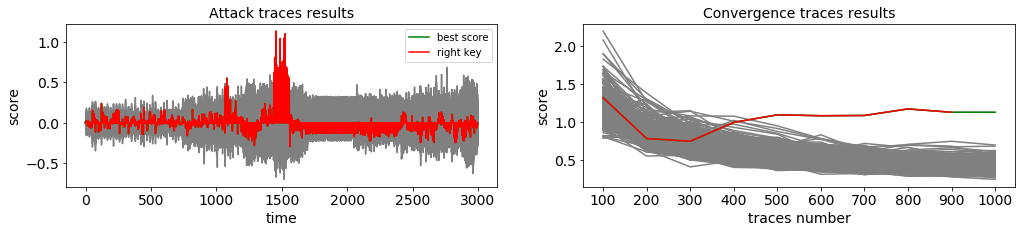

Best guess for byte 2 = 0xe7
Correct guess for byte : 2=0xe7


In [25]:
plot_attack_result(attack_dpa_1stRound, 2, ths[0].key)

#### The key is recovered from 500 traces.